In [1]:
epochs = 5

# Example - Simple Vertically Partitioned Split Neural Network

- <b>Alice</b>
    - Has model Segment 1
    - Has the handwritten Images
- <b>Bob</b>
    - Has model Segment 2
    - Has the image Labels
    
Based on [SplitNN - Tutorial 3](https://github.com/OpenMined/PySyft/blob/master/examples/tutorials/advanced/split_neural_network/Tutorial%203%20-%20Folded%20Split%20Neural%20Network.ipynb) from Adam J Hall - Twitter: [@AJH4LL](https://twitter.com/AJH4LL) · GitHub:  [@H4LL](https://github.com/H4LL)

Authors:
- Pavlos Papadopoulos · GitHub:  [@pavlos-p](https://github.com/pavlos-p)
- Tom Titcombe · GitHub:  [@TTitcombe](https://github.com/TTitcombe)
- Robert Sandmann · GitHub: [@rsandmann](https://github.com/rsandmann)


In [2]:
class SplitNN:
    def __init__(self, models, optimizers):
        self.models = models
        self.optimizers = optimizers

        self.data = []
        self.remote_tensors = []

    def forward(self, x):
        data = []
        remote_tensors = []

        data.append(self.models[0](x))

        if data[-1].location == self.models[1].location:
            remote_tensors.append(data[-1].detach().requires_grad_())
        else:
            remote_tensors.append(
                data[-1].detach().move(self.models[1].location).requires_grad_()
            )

        i = 1
        while i < (len(models) - 1):
            data.append(self.models[i](remote_tensors[-1]))

            if data[-1].location == self.models[i + 1].location:
                remote_tensors.append(data[-1].detach().requires_grad_())
            else:
                remote_tensors.append(
                    data[-1].detach().move(self.models[i + 1].location).requires_grad_()
                )

            i += 1

        data.append(self.models[i](remote_tensors[-1]))

        self.data = data
        self.remote_tensors = remote_tensors

        return data[-1]

    def backward(self):
        for i in range(len(models) - 2, -1, -1):
            if self.remote_tensors[i].location == self.data[i].location:
                grads = self.remote_tensors[i].grad.copy()
            else:
                grads = self.remote_tensors[i].grad.copy().move(self.data[i].location)
    
            self.data[i].backward(grads)

    def zero_grads(self):
        for opt in self.optimizers:
            opt.zero_grad()

    def step(self):
        for opt in self.optimizers:
            opt.step()

In [3]:
import sys
sys.path.append('../')

import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy

from src.dataloader import VerticalDataLoader
from src.psi.util import Client, Server
from src.utils import add_ids

hook = sy.TorchHook(torch)

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/home/pavlito/miniconda3/envs/pyvertical-dev/lib/python3.7/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.3.so'


In [4]:
# Create dataset
data = add_ids(MNIST)(".", download=True, transform=ToTensor())  # add_ids adds unique IDs to data points

# Batch data
dataloader = VerticalDataLoader(data, batch_size=128) # partition_dataset uses by default "remove_data=True, keep_order=False"

## Check if the datasets are unordered
In MNIST, we have 2 datasets (the images and the labels).

7 1 6 8 7 5 9 6 7 8 

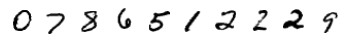

In [5]:
# We need matplotlib library to plot the dataset
import matplotlib.pyplot as plt

# Plot the first 10 entries of the labels and the dataset
figure = plt.figure()
num_of_entries = 10
for index in range(1, num_of_entries + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(dataloader.dataloader1.dataset.data[index].numpy().squeeze(), cmap='gray_r')
    print(dataloader.dataloader2.dataset[index][0], end=" ")

## Implement PSI and order the datasets accordingly

In [6]:
# Compute private set intersection
client_items = dataloader.dataloader1.dataset.get_ids()
server_items = dataloader.dataloader2.dataset.get_ids()

client = Client(client_items)
server = Server(server_items)

setup, response = server.process_request(client.request, len(client_items))
intersection = client.compute_intersection(setup, response)

# Order data
dataloader.drop_non_intersecting(intersection)
dataloader.sort_by_ids()

## Check again if the datasets are ordered

6 0 3 5 5 8 5 6 6 6 

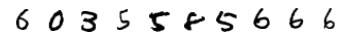

In [7]:
# We need matplotlib library to plot the dataset
import matplotlib.pyplot as plt

# Plot the first 10 entries of the labels and the dataset
figure = plt.figure()
num_of_entries = 10
for index in range(1, num_of_entries + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(dataloader.dataloader1.dataset.data[index].numpy().squeeze(), cmap='gray_r')
    print(dataloader.dataloader2.dataset[index][0], end=" ")

In [8]:
torch.manual_seed(0)

# Define our model segments

input_size = 784
hidden_sizes = [128, 640]
output_size = 10

models = [
    nn.Sequential(
        nn.Linear(input_size, hidden_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        nn.ReLU(),
    ),
    nn.Sequential(nn.Linear(hidden_sizes[1], output_size), nn.LogSoftmax(dim=1)),
]

# Create optimisers for each segment and link to them
optimizers = [
    optim.SGD(model.parameters(), lr=0.03,)
    for model in models
]

# create some workers
alice = sy.VirtualWorker(hook, id="alice")
bob = sy.VirtualWorker(hook, id="bob")

# Send Model Segments to model locations
model_locations = [alice, bob]
for model, location in zip(models, model_locations):
    model.send(location)

#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = SplitNN(models, optimizers)

In [9]:
def train(x, target, splitNN):
    
    #1) Zero our grads
    splitNN.zero_grads()
    
    #2) Make a prediction
    pred = splitNN.forward(x)
    
    #3) Figure out how much we missed by
    criterion = nn.NLLLoss()
    loss = criterion(pred, target)
    
    #4) Backprop the loss on the end layer
    loss.backward()
    
    #5) Feed Gradients backward through the nework
    splitNN.backward()
    
    #6) Change the weights
    splitNN.step()
    
    return loss, pred

In [10]:
for i in range(epochs):
    running_loss = 0
    correct_preds = 0
    total_preds = 0

    for (data, ids1), (labels, ids2) in dataloader:
        # Train a model
        data = data.send(models[0].location)
        data = data.view(data.shape[0], -1)
        labels = labels.send(models[-1].location)

        # Call model
        loss, preds = train(data, labels, splitNN)

        # Collect statistics
        running_loss += loss.get()
        correct_preds += preds.max(1)[1].eq(labels).sum().get().item()
        total_preds += preds.get().size(0)

    print(f"Epoch {i} - Training loss: {running_loss/len(dataloader):.3f} - Accuracy: {100*correct_preds/total_preds:.3f}")

Epoch 0 - Training loss: 1.145 - Accuracy: 73.035
Epoch 1 - Training loss: 0.385 - Accuracy: 89.175
Epoch 2 - Training loss: 0.317 - Accuracy: 90.955
Epoch 3 - Training loss: 0.281 - Accuracy: 91.968
Epoch 4 - Training loss: 0.254 - Accuracy: 92.710


In [11]:
print("Labels pointing to: ", labels)
print("Images pointing to: ", data)

Labels pointing to:  (Wrapper)>[PointerTensor | me:88412365445 -> bob:61930132897]
Images pointing to:  (Wrapper)>[PointerTensor | me:17470208323 -> alice:25706803556]
